In [1]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
import json
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

In [2]:
import numpy as np

from src.optics.channel_simulation2 import ChannelSimulator2
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ChannelConfig


# Channel Simulation
here starts the actual channel simulator code.

In [3]:
conf = ChannelConfig(
    W = 0.05,             # Total bandwidth, estimated [THz]
    Nspans = 12,            # The number of spans
    span_length = 80,       # Transmission span [km]
    M_QAM = 16,             # QAM order (2,4,16,64,256)
    Ts = 1,               # Symbol period [??]

    # Modulation and Coding:
    Nos = 16,               # Oversampling factor (must be even)
    eta = 2,                # spectral efficiency penalty factor (1,4]
    mu = 0.15,             # Dimensionless power scaling factor (RRC)
    bet = 0.2,            # roll-off factor
    with_ssf = True,       # whether to use SSF or not
    with_noise = True,     # whether to add noise or not

    # Fiber and Dispersion:
    alphadB = 0.2,        # Power loss db/km
    beta2 = -21,          # ps^2/km
    gamma = 1.27,         # Nonlinear coefficient in [1/km*W]
    dz = 0.2,             # Z-step, [km] - initial step estimate
)

In [4]:
cs: ChannelSimulator2 = ChannelSimulator2(conf)


Z_0 = 1248304.761904762


In [5]:
print('conf')
print(cs.configs)

conf
ChannelBlocksConfigs(input_generator_config=InputGeneratorConfig(M_QAM=16, N_sc=256), modulator_config=ModulatorConfig(M_QAM=16), over_sampler_config=OverSamplingConfig(N_os=16), spectral_shaping_config=SpectralShaperConfig(bet=0.2, Ts=1, Nos=16), pre_equalizer_config=PreEqualizerConfig(mu=0.15, span_length=80, Zn=87833.13612677579), inft_config=INFTConfig(Pn=3.387832219149323e-05), ssf_config=SSFConfig(beta2=-21, gamma_eff=0.3360622388307512, T0=5120.0, dz=0.2, span_length=80, with_ssf=True, with_noise=True, Pn=3.387832219149323e-05), nft_config=NFTConfig(), post_equalizer_config=PostEqualizerConfig(Zn=87833.13612677579, mu=0.15, span_length=80, with_ssf=True), match_filter_config=MatchFilterConfig(Nos=16, bet=0.2, Ts=1), decoder_config=DecoderConfig(M_QAM=16), evaluator_config=EvaluatorConfig(M_QAM=16, N_sc=256, verbose=False))


In [6]:
print('extra inputs:')
print(cs.extra_inputs)

extra inputs:
{'xi': array([-128.    , -127.9375, -127.875 , ...,  127.8125,  127.875 ,
        127.9375]), 'xi_padded': array([-511.9375, -511.875 , -511.8125, ...,  511.875 ,  511.9375,
        512.    ]), 't': array([-5120.83333333, -5116.66666667, -5112.5       , ...,
        5108.33333333,  5112.5       ,  5116.66666667]), 't_padded': array([-25.13274123, -25.12967327, -25.12660531, ...,  25.12353734,
        25.12660531,  25.12967327]), 'Nnft': 16384, 'Nb': 2458, 'Ns': 4096, 'dt': 4.166666666666667}


In [7]:
cs.simulate()

D = 7.380872847728679e-08
noise_amplitude = 5.952158404234355e-05
P_0 = 0.023837442390684537


(0.0859375, 88)

[[0 0 0 1]
 [0 1 1 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [1 0 1 0]
 [1 0 0 1]]


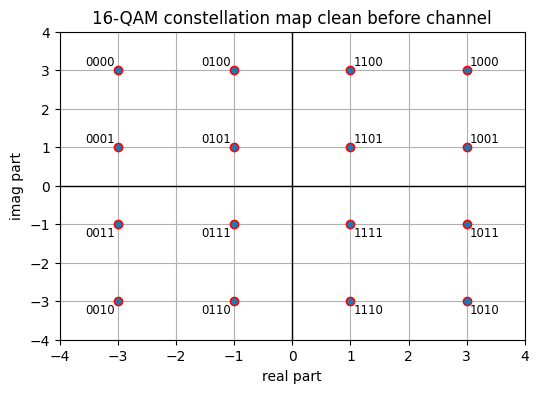

In [8]:
cs.blocks[0].get_output_names()
M_QAM = conf.M_QAM
sps = int(np.log2(M_QAM))
message_s_bin, c_in = cs.blocks[0].get_outputs()
bin_txt = np.reshape(message_s_bin, (-1, sps))
print(bin_txt)
Visualizer.plot_constellation_map_with_points(c_in, M_QAM, 'clean before channel')



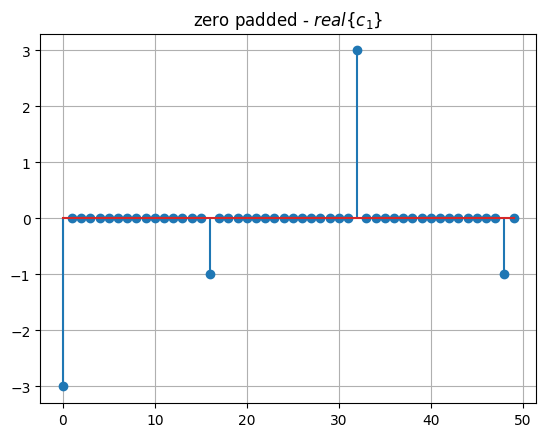

In [9]:
cs.blocks[1].get_output_names()
c_in1 = cs.blocks[1].get_outputs()[0]
Visualizer.my_plot(range(50), np.real(c_in1[0:50]), name='zero padded - $ real\{c_1 \} $', function='stem')

length of u_in: 4096
length of xi: 4096


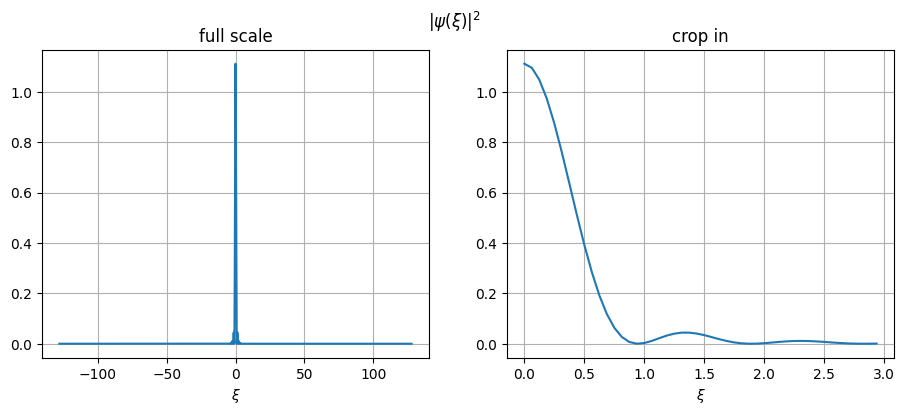

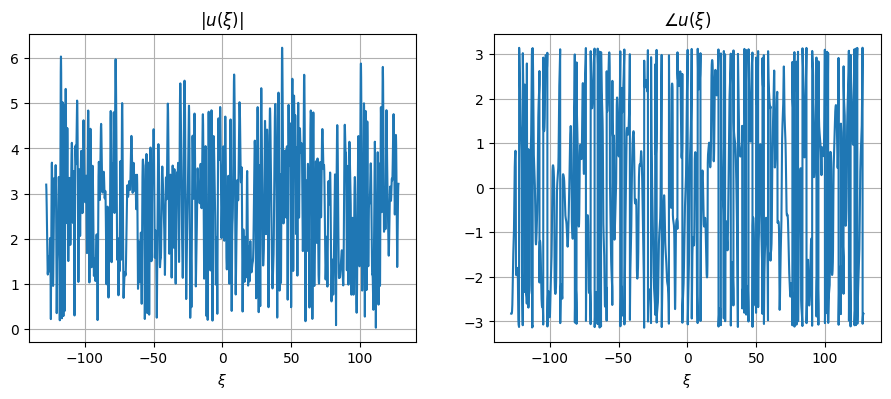

In [10]:
cs.blocks[2].get_output_names()
u_in, psi_xi, psi_t = cs.blocks[2].get_outputs()
xi = cs.extra_inputs['xi']
Ns = cs.extra_inputs['Ns']
Nos = conf.Nos
print(f'length of u_in: {len(u_in)}')
print(f'length of xi: {len(xi)}')
zm = range(Ns//2, Ns//2 + Nos*3)
Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(psi_xi) ** 2, zm, xi, xlabel=r'$\xi$')
Visualizer.plot_amp_and_phase(xi,u_in,r'$\xi$',r'u(\xi)')

length of b_padded: 16384


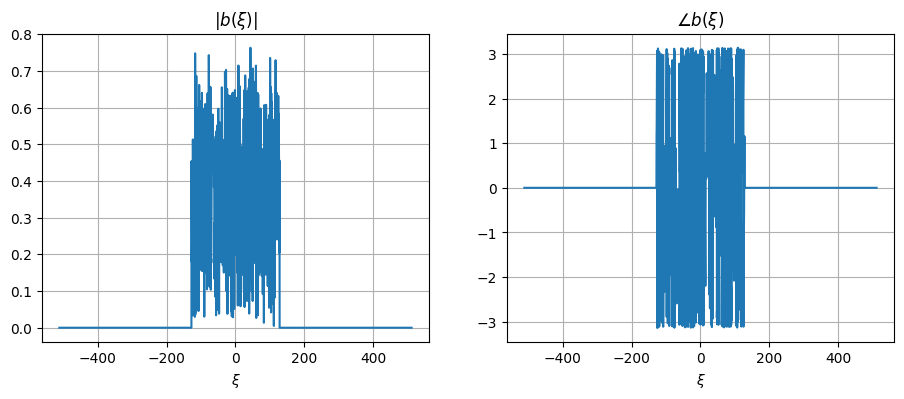

In [11]:
cs.blocks[3].get_output_names()
u1, b_in1, b_in, b_in_padded = cs.blocks[3].get_outputs()
print(f'length of b_padded: {len(b_in_padded)}')
xi_padded = cs.extra_inputs['xi_padded']
Visualizer.plot_amp_and_phase(xi_padded, b_in_padded, r'$\xi$', r'b(\xi)')

 length of t: 2458


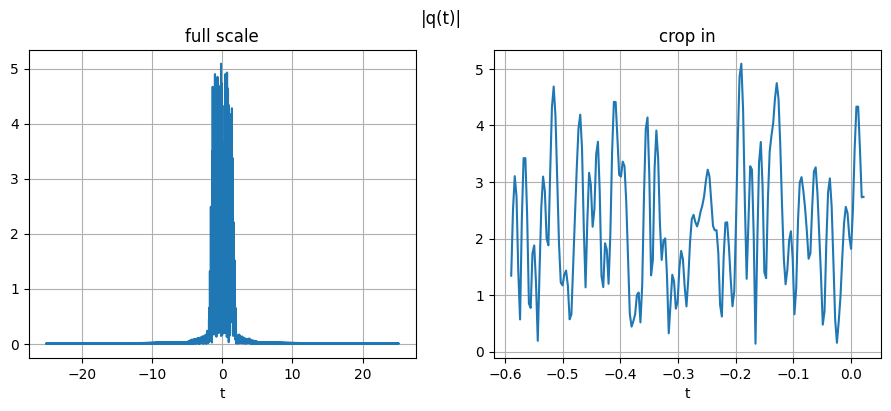

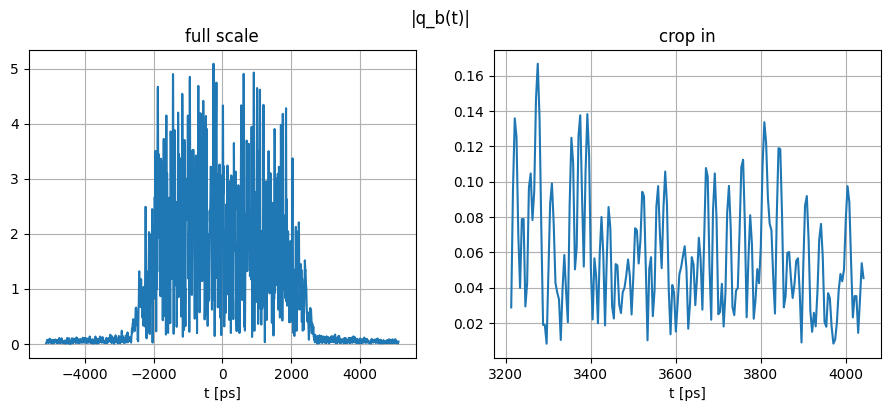

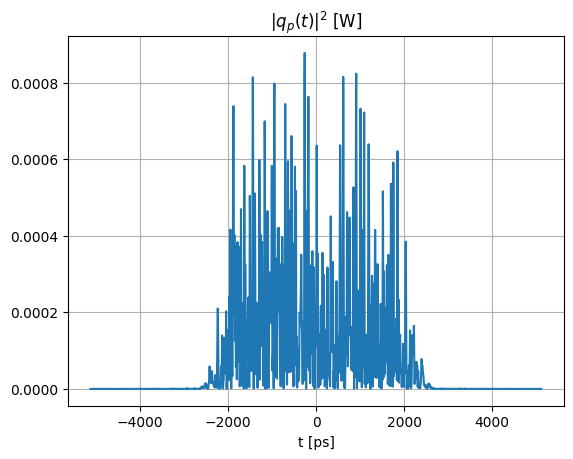

In [12]:
cs.blocks[4].get_output_names()
q_in, qb, q_p = cs.blocks[4].get_outputs()
t_padded = cs.extra_inputs['t_padded']
t = cs.extra_inputs['t']
print(f' length of t: {len(t)}')

Visualizer.twin_zoom_plot('|q(t)|', np.abs(q_in), range(8000, 8200), t_padded, 't')
Visualizer.twin_zoom_plot('|q_b(t)|', np.abs(qb), range(2000, 2200), t, 't [ps]')
Visualizer.my_plot(t, np.abs(q_p)**2, name=r'$|q_p(t)|^2$ [W]', xlabel='t [ps]')


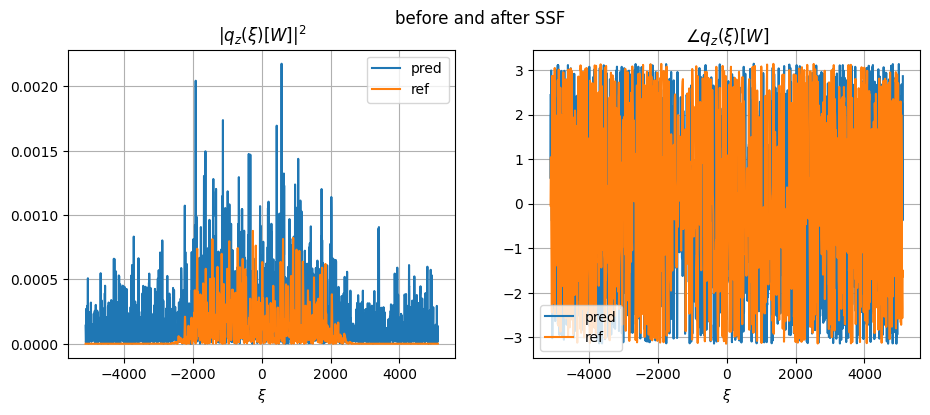

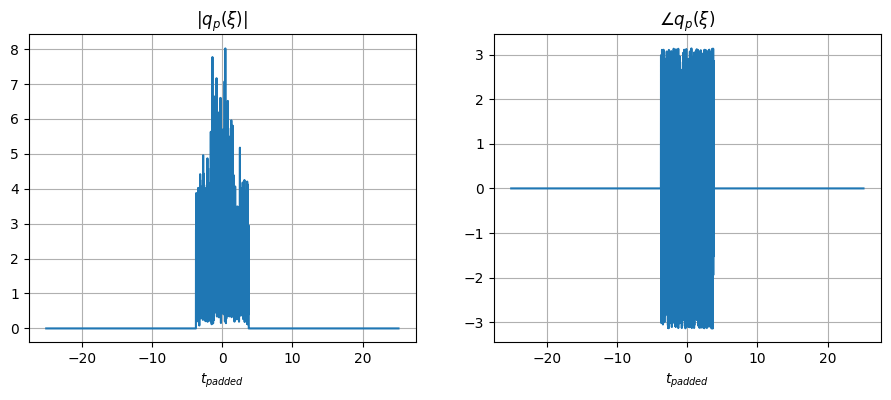

In [13]:
# cs.blocks[5].config
cs.blocks[5].get_output_names()
qz, q_s, q_pad = cs.blocks[5].get_outputs()

Visualizer.compare_amp_and_phase(t, qz, q_p, r'$\xi$', r'q_z(\xi) [W]','before and after SSF')
Visualizer.plot_amp_and_phase(t_padded, q_pad, r'$t_{padded}$', r'q_p(\xi)')

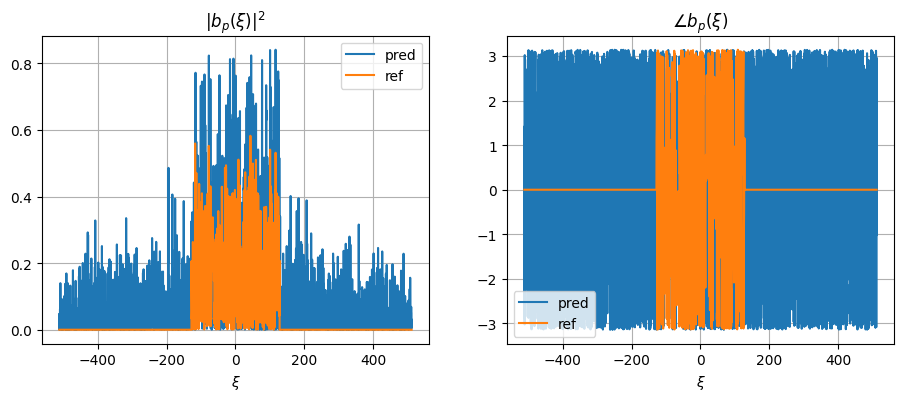

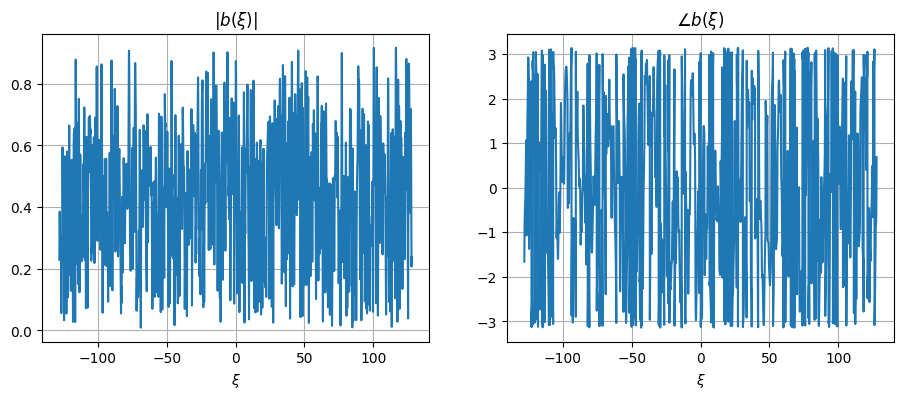

In [14]:
cs.blocks[6].get_output_names()
b_out_padded, b_out = cs.blocks[6].get_outputs()

Visualizer.compare_amp_and_phase(xi_padded, b_out_padded, b_in_padded, r'$\xi$', r'b_p(\xi)',"")
Visualizer.plot_amp_and_phase(xi, b_out, r'$\xi$', r'b(\xi)')

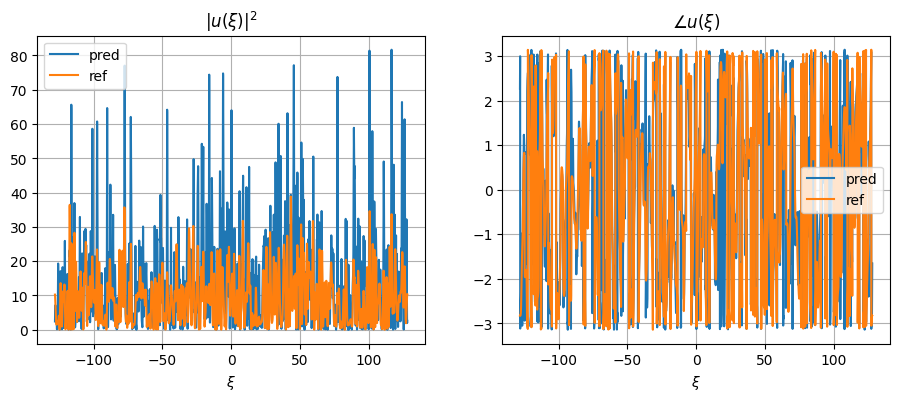

In [15]:
cs.blocks[7].get_output_names()
b_out1, u1_out, u_out = cs.blocks[7].get_outputs()

Visualizer.compare_amp_and_phase(xi,u_out, u_in, r'$\xi$', r'u(\xi)', "")

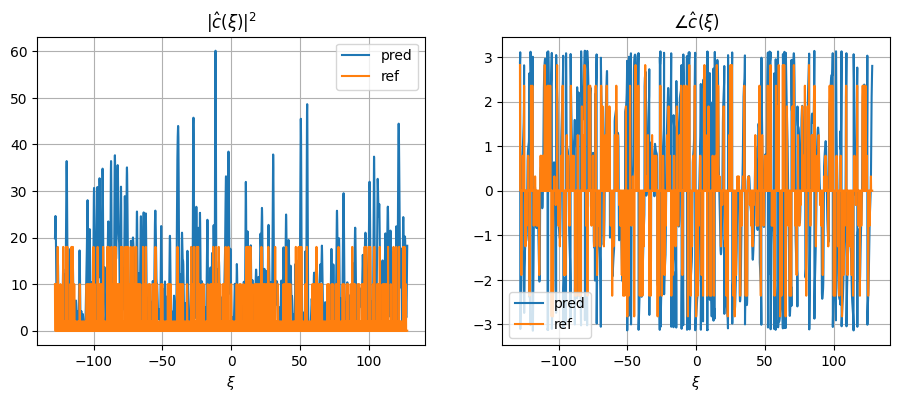

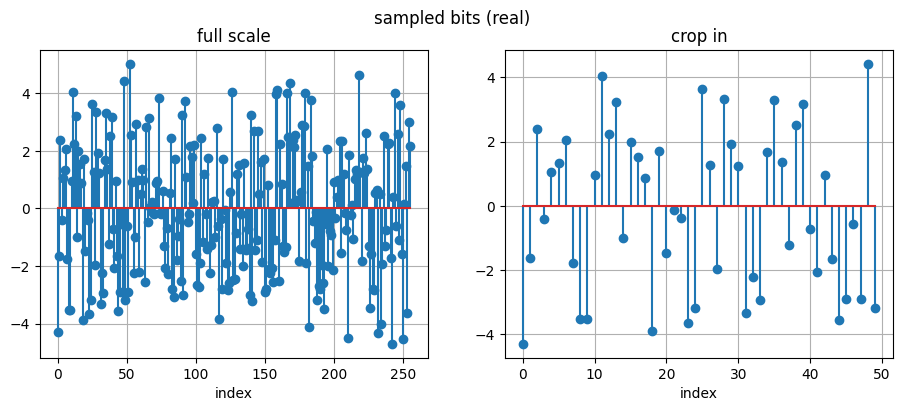

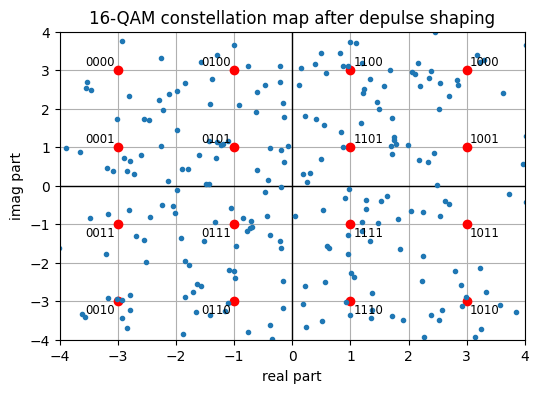

In [16]:
cs.blocks[8].get_output_names()
c_out1, c_out = cs.blocks[8].get_outputs()


Visualizer.compare_amp_and_phase(xi, c_out1,c_in1, r'$\xi$', r'\hat c(\xi)', "")
Visualizer.twin_zoom_plot('sampled bits (real)',np.real(c_out),range(0,50),function='stem')
Visualizer.plot_constellation_map_with_points(c_out, M_QAM, 'after depulse shaping')


In [17]:
cs.blocks[9].get_output_names()
s_out = cs.blocks[9].get_outputs()[0]
Visualizer.print_bits(s_out, sps, 'message after channel')



_______________________________________________
message after channel - len=1024
[[0. 0. 0. 1.]
 [0. 1. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]]


In [18]:
cs.block11.verbose = True
cs.block11.calc_ber(s_out,message_s_bin)

ber = 0.0859375 = 88/1024.0


(88, 0.0859375)